In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import teotil3 as teo

plt.style.use("ggplot")

In [3]:
eng = nivapy.da.connect_postgis()

Connection successful.


# Numedalslågen: Point discharges

In [4]:
st_yr, end_yr = 2013, 2023
cat_shp = r"../data/numedalslagen_catchment.shp"

,site_id,site_name,sector,type,site_x_utm33,site_y_utm33,outlet_x_utm33,outlet_y_utm33,year,DIN_kg,SS_kg,TDP_kg,TOC_kg,TON_kg,TOTN_kg,TOTP_kg,TPP_kg
0,0604AL47,Sellikdalen,Large wastewater,Kjemisk,198501.581829,6.624388e+06,198636.787523,6.624482e+06,2013,52593.4,63506.3,78.8,63728.6,20453.0,73046.3,606.4,527.6
1,0604AL47,Sellikdalen,Large wastewater,Kjemisk,198501.581829,6.624388e+06,198636.787523,6.624482e+06,2014,72783.7,78.1,76.6,72777.5,28304.8,101088.5,588.9,512.4
2,0604AL47,Sellikdalen avløpsanlegg,Large wastewater,Kjemisk,198501.581829,6.624388e+06,198636.787523,6.624482e+06,2015,57888.0,NaN,106.5,78087.9,22512.0,80400.0,819.0,712.5
3,0604AL47,Sellikdalen avløpsanlegg,Large wastewater,Kjemisk,198600.151532,6.624566e+06,198636.787523,6.624482e+06,2016,62352.0,NaN,44.6,70755.3,24248.0,86600.0,343.0,298.4
4,0604AL47,Sellikdalen avløpsanlegg,Large wastewater,Kjemisk,198600.151532,6.624566e+06,198636.787523,6.624482e+06,2017,68244.1,NaN,24.6,74073.1,26539.4,94783.4,189.1,164.6


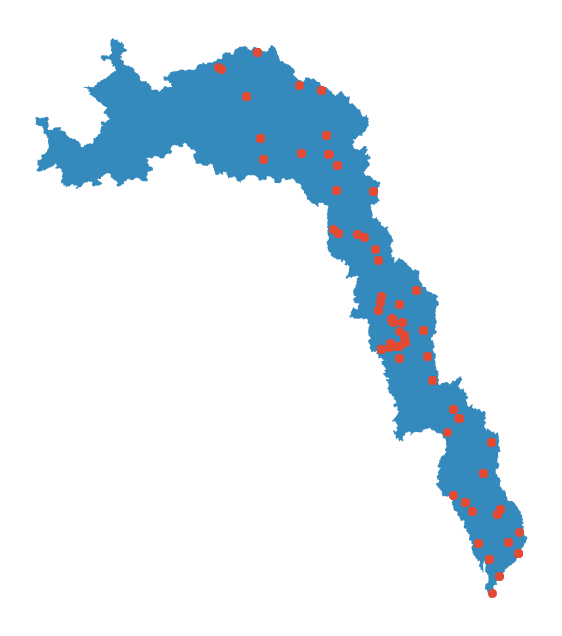

In [5]:
# Get catchment boundary
cat_gdf = gpd.read_file(cat_shp).rename(columns={"site_id": "cat_id"})

# Get point data
df_list = []
for year in range(st_yr, end_yr + 1):
    for src in ["industry", "large wastewater"]:
        df = teo.io.get_raw_annual_point_data(
            eng,
            year,
            src,
        )
        df_list.append(df)
pt_df = pd.concat(df_list, axis="rows").reset_index(drop=True)
pt_df["vassom"] = pt_df["regine"].str.split(".").str[0].astype(int)
pt_df = pt_df.query("vassom == 15")

# Convert to point gdf
pt_gdf = gpd.GeoDataFrame(
    pt_df,
    geometry=gpd.points_from_xy(
        pt_df["outlet_x_utm33"], pt_df["outlet_y_utm33"], crs="epsg:25833"
    ),
)

# Filter stations to just those within catchment boundary
stn_cols = list(pt_df.columns)
pt_gdf = gpd.sjoin(pt_gdf, cat_gdf, predicate="within", how="inner")[
    stn_cols + ["geometry"]
].reset_index(drop=True)
pt_df = (
    pt_gdf.drop(columns=["regine", "vassom", "geometry"])
    .sort_values(["site_id", "year"])
    .reset_index(drop=True)
)

# Plot
ax = cat_gdf.plot(figsize=(8, 8))
pt_gdf.plot(ax=ax)
ax.axis("off")

# Save
xl_path = f"../data/numedalslagen_industry_large-wastewater_{st_yr}-{end_yr}.xlsx"
pt_df.to_excel(xl_path, index=False)

pt_df.head()